In [265]:
import json
import decimal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [266]:
class DecimalEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, decimal.Decimal):
            return str(o)
        return super(DecimalEncoder, self).default(o)


In [267]:
import boto3
from boto3.dynamodb.conditions import Key

inst = "CL"
db = boto3.resource('dynamodb', region_name='us-east-1',
                    endpoint_url="https://dynamodb.us-east-1.amazonaws.com")
table = db.Table("mktData")
j = table.scan() 


In [271]:
frames = []
c = 1
for d in j["Items"]:
    d2 = eval(d["data"])
    dtg = d["dtg"]
    df = pd.read_json(d2, orient="split")
    df["dtg"] = dtg
    df["col"] = c
    c = c+1
    frames.append(df)
df = pd.concat(frames)

In [272]:
df['Side'] = np.where(df['Financial Instrument'].str.contains("PUT"), "p", "c")

df['Put'] = np.where(df['Side'] == "p", 1, 0)
df['Call'] = np.where(df['Side'] == "c", 1, 0)
df['Days'] = df['Days to Last Trading Day'] / 365
df = df[df['Implied Vol. %'] != "N/A"]
df['Vol'] = df['Implied Vol. %'].str.replace('%', '')
df['Vol'] = df['Vol'].astype(float) / 100
df['Strike'] = df['Financial Instrument'].str.split(" ").map(lambda x: x[4])
df['Strike'] = df['Strike'].astype(float)
print(df[["Strike", "Days", "Vol"]].describe())

            Strike         Days          Vol
count  6258.000000  6258.000000  5373.000000
mean     69.464366     0.271502     0.371431
std      12.265727     0.152801     0.121038
min      40.000000     0.013699     0.253000
25%      59.500000     0.156164     0.309000
50%      69.500000     0.268493     0.342000
75%      80.000000     0.413699     0.393000
max      90.000000     0.534247     1.345000


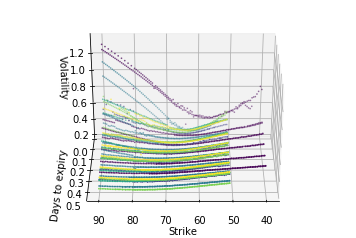

In [274]:
#%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df["Strike"], df["Days"], df["Vol"],  
           c=df["col"],
           s=0.5
           )
ax.set_xlabel("Strike")
ax.set_ylabel("Days to expiry")
ax.set_zlabel("Volatility")
ax.view_init(30, 90)
plt.draw()


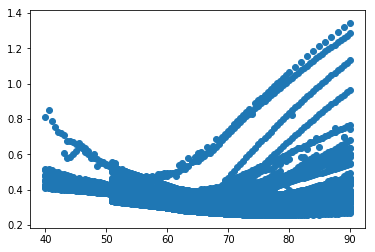

In [262]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df["Strike"], df["Vol"])
#fig.title(dtg)
#fig.show()